In [1]:
import pandas as pd
import os
import sys
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gensim
from gensim.utils import simple_preprocess
import spacy
from wordcloud import WordCloud

In [2]:
data_frame = pd.read_csv('IMDB Dataset.csv')
data_frame

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df = data_frame.copy()

In [4]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
df.shape

(50000, 2)

In [6]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df.duplicated().sum()

418

In [8]:
duplicated_rows = df[df.duplicated()]
duplicated_rows

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [9]:
df = df.drop_duplicates()

In [11]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [12]:
df.shape

(49582, 2)

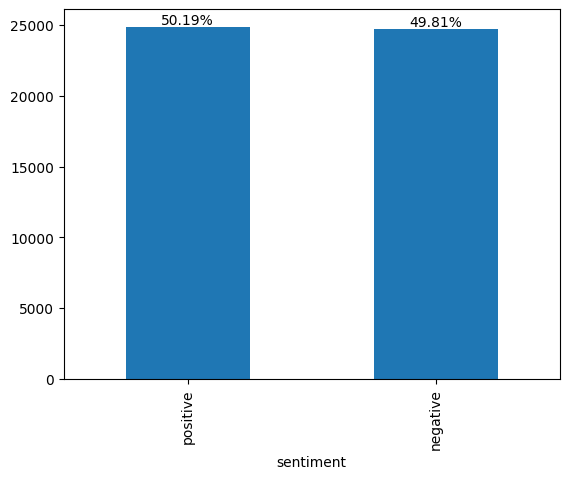

In [31]:
ax = df['sentiment'].value_counts().plot(kind='bar')
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    text = '{:.2f}%'.format(y / len(df) * 100)
    ax.text(x, y, text, ha='center', va='bottom', fontsize=10, color='black')
plt.show()

In [34]:
#text preprocessing
def lower_case(txt):
    return (txt.lower())
    
df['review'] = df['review'].apply(lower_case)

In [35]:
df['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

In [36]:
#word tokenization
def tokenize_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

In [38]:
data = df['review'].tolist()[:500]

In [41]:
data_words = list(tokenize_words(data))

In [42]:
data_words[:1]

[['one',
  'of',
  'the',
  'other',
  'reviewers',
  'has',
  'mentioned',
  'that',
  'after',
  'watching',
  'just',
  'oz',
  'episode',
  'you',
  'll',
  'be',
  'hooked',
  'they',
  'are',
  'right',
  'as',
  'this',
  'is',
  'exactly',
  'what',
  'happened',
  'with',
  'me',
  'br',
  'br',
  'the',
  'first',
  'thing',
  'that',
  'struck',
  'me',
  'about',
  'oz',
  'was',
  'its',
  'brutality',
  'and',
  'unflinching',
  'scenes',
  'of',
  'violence',
  'which',
  'set',
  'in',
  'right',
  'from',
  'the',
  'word',
  'go',
  'trust',
  'me',
  'this',
  'is',
  'not',
  'show',
  'for',
  'the',
  'faint',
  'hearted',
  'or',
  'timid',
  'this',
  'show',
  'pulls',
  'no',
  'punches',
  'with',
  'regards',
  'to',
  'drugs',
  'sex',
  'or',
  'violence',
  'its',
  'is',
  'hardcore',
  'in',
  'the',
  'classic',
  'use',
  'of',
  'the',
  'word',
  'br',
  'br',
  'it',
  'is',
  'called',
  'oz',
  'as',
  'that',
  'is',
  'the',
  'nickname',
  'gi